# Time series denoising

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib import pyplot as plt
import copy

# Required for interactive plots in DataSpell
# import matplotlib
# matplotlib.use("nbagg")

## Load data

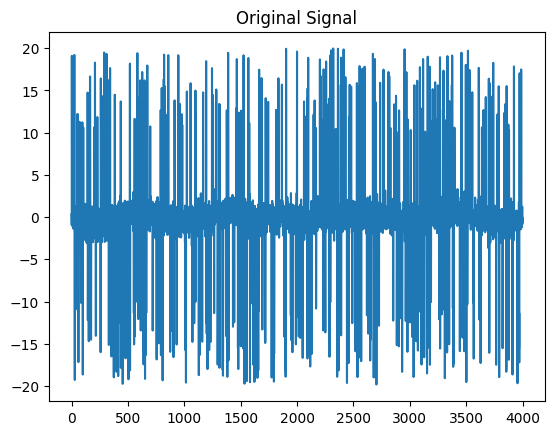

In [2]:
challengeData = sio.loadmat("Datasets/denoising_codeChallenge.mat")
origSignal = challengeData['origSignal'][0]
cleanedSignal = challengeData['cleanedSignal'][0]

n = origSignal.size

# Preview original signal
plt.figure()
plt.title("Original Signal")
plt.plot(origSignal)
plt.show()

### TKEO
We can see many short and intense spikes, lets see what TKEO does for us:

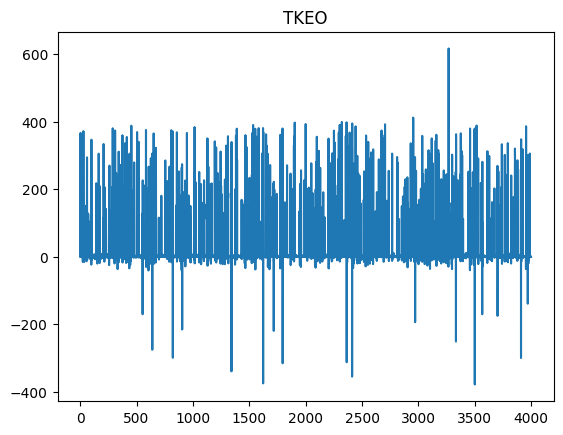

In [3]:
TKEOProcessedSignal = copy.deepcopy(origSignal)
for i in range(1, n - 1):
    TKEOProcessedSignal[i] = origSignal[i]**2 - (origSignal[i-1] * origSignal[i+1])

plt.figure()
plt.title("TKEO")
# plt.plot(origSignal, label="Original")
plt.plot(TKEOProcessedSignal, label="TKEO")
# plt.legend()
plt.show()

### Median filter
Unfortunately, TKEO was unable to magically remove all spikes. Perhaps a selectively-applied median filter will do better?
First, generate a histogram to determine a threshold.

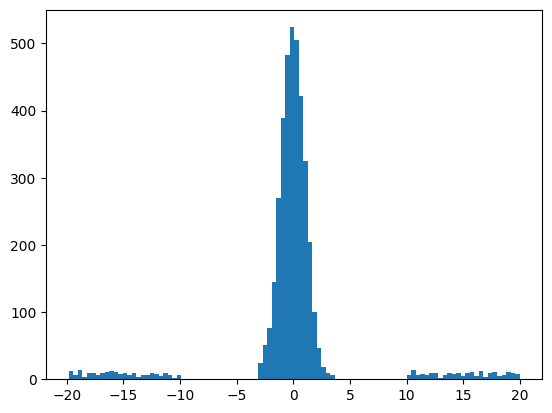

In [4]:
plt.figure()
plt.hist(origSignal, 100)
plt.show()

We can see that most of the signal is contained between (-5, 5), so lets select all points outside this range for our filter.

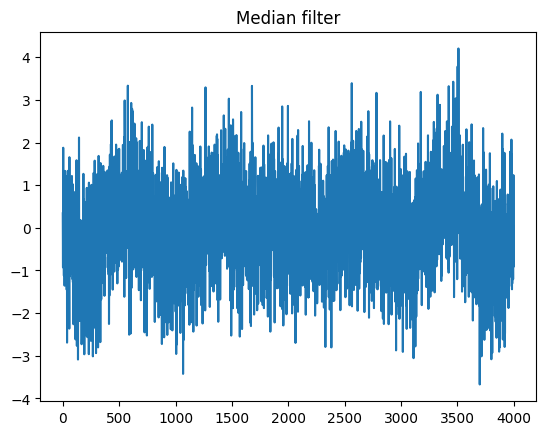

In [5]:
threshold = 5

# find data values above the threshold
suprassedThresh = np.where(np.abs(origSignal) > threshold)[0]

MedianFilterProcessedSignal = copy.deepcopy(origSignal)
k = 5
for i in suprassedThresh:

    # Make sure to stay within bounds
    begin = max(0, i - k)
    end = min(n, i + k)

    MedianFilterProcessedSignal[i] = np.median(origSignal[begin:end])

plt.figure()
plt.title("Median filter")
# plt.plot(origSignal, label="Original")
plt.plot(MedianFilterProcessedSignal, label="Median filter")
# plt.legend()
plt.show()

### Mean-smooting
Now, that is a lot better! We can still see a lot of noise, wich we will try to removing using a running mean (moving average) filter.

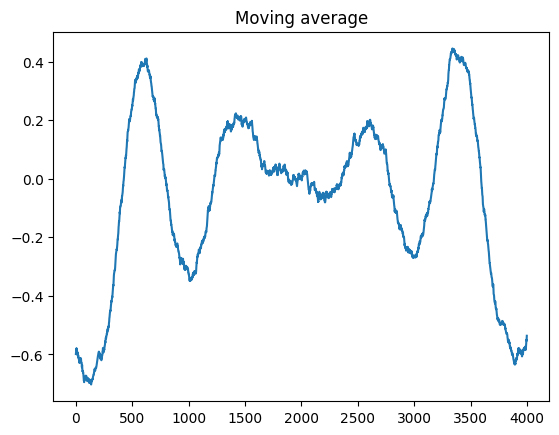

In [6]:
MovingAverageProcessedSignal = copy.deepcopy(MedianFilterProcessedSignal)
k = 200
for i in range(n):

    # Overcome edge-effects by still averaging the edges
    begin = max(0, i - k)
    end = min(n, i + k)

    MovingAverageProcessedSignal[i] = np.mean(MedianFilterProcessedSignal[begin:end])

plt.figure()
plt.title("Moving average")
# plt.plot(origSignal, label="Original")
plt.plot(MovingAverageProcessedSignal, label="Moving average")
# plt.legend()
plt.show()

### Gaussion-smoothing
Looks pretty good! Perhaps, still a bit too noisy. What if we instead gaussian-smooth the signal?

First, we will create the gaussion function.

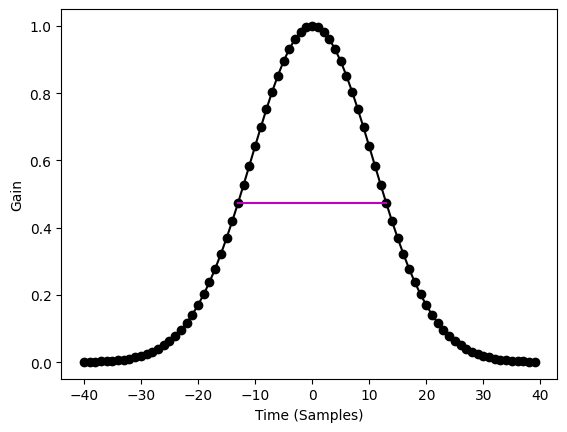

In [7]:
## Create Gaussian kernel
# Full-width half-maximum: the key Gaussian parameter. The width of the curve at y=0.5.
fwhm = 25

# Time vector, the left and right trails should go to 0, but not be excessively long
k = 40
gtime = np.arange(-k, k)

# Create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# Compute empirical FWHM (For visualization, not filtering)
pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )
empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# Show the Gaussian
plt.figure()

plt.plot(gtime,gauswin,'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

# Then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)

plt.xlabel('Time (Samples)')
plt.ylabel('Gain')

plt.show()

Looks good! Make sure to tweak the k and fhwm parameters to suit the data. Now, lets apply the filter.

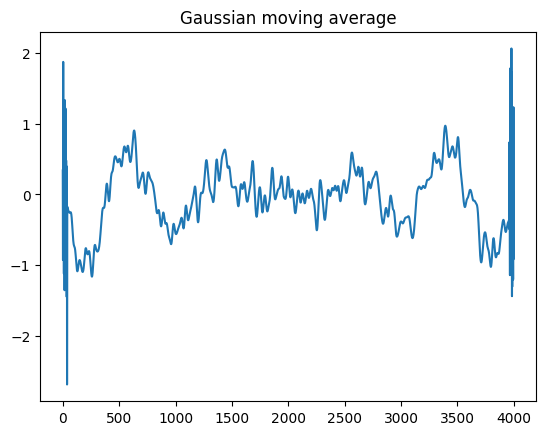

In [8]:
GaussianProcessedSignal = copy.deepcopy(MedianFilterProcessedSignal)
for i in range(k, n - k):
    GaussianProcessedSignal[i] = np.sum(MedianFilterProcessedSignal[i - k:i + k] * gauswin)

plt.figure()
plt.title("Gaussian moving average")
# plt.plot(origSignal, label="Original")
plt.plot(GaussianProcessedSignal, label="Gaussian moving average")
# plt.legend()
plt.show()

### Comparason
Unfortunate of the edge-effects. However, the data looks very smooth. Lets compare the results.

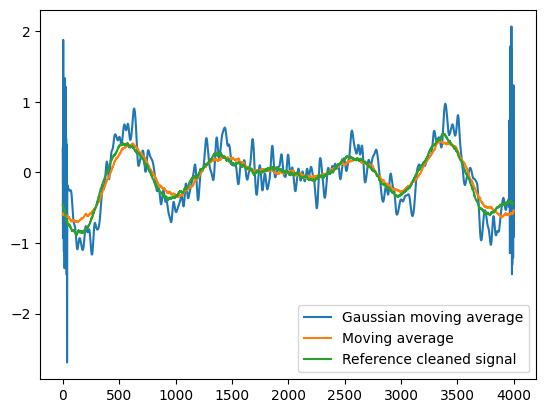

In [9]:
plt.figure()
plt.plot(GaussianProcessedSignal, label="Gaussian moving average")
plt.plot(MovingAverageProcessedSignal, label="Moving average")
plt.plot(cleanedSignal, label="Reference cleaned signal")
plt.legend()
plt.show()

## Summary
It is clear that TKEO does not work properly, this is because we require peaks that are even more significant (like EMG data).

However, applying a median filter to the selected peaks seemed to work really well. This gave us some data with gaussian noise around it.

We then smoothed this noisy data with a mean-smooth and gaussian-smooth filter and compared the results. The gaussian-smoothed signal looks cleaner (smoother), but still contained some local oscillations, this could perhaps be removed with a wider gaussian. However, there is no way around the noisy edge-effects, wich would increase with a wider gaussian.

If we instead apply a mean-smoothing filter, we can see that we can overcome the significant edge effects and our data now looks comparable to the reference. Succes!